# Task

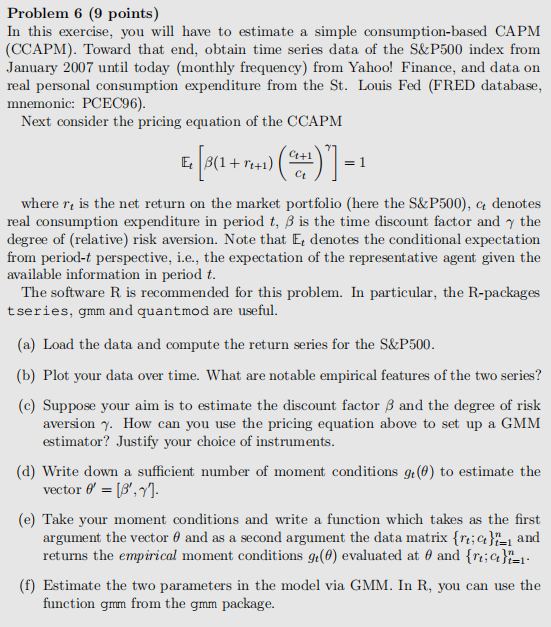

# Python solution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# a) and b)

In [2]:
# S&P500 index from Investing.com
SP500 = pd.read_csv('https://raw.githubusercontent.com/winterForestStump/econometrics/refs/heads/main/assignment_3/S%26P%20500%20Historical%20Data.csv')
SP500['Price'] = SP500['Price'].str.replace(',','').astype(float)
SP500['Open'] = SP500['Open'].str.replace(',','').astype(float)
SP500['High'] = SP500['High'].str.replace(',','').astype(float)
SP500['Low'] = SP500['Low'].str.replace(',','').astype(float)
SP500['Change %'] = SP500['Change %'].str.replace('%','').astype(float)
SP500['Date'] = pd.to_datetime(SP500['Date'])
SP500 = SP500.sort_values(by='Date', ascending=True)
SP500 = SP500[:-2].reset_index() #drop the last 2 months
SP500 = SP500.drop(columns=['index', 'Open', 'High', 'Low', 'Vol.', 'Change %'])

# Real personal consumption expenditure from the St. Louis Fed (FRED database, mnemonic: PCEC96).
PCEC96 = pd.read_csv('https://raw.githubusercontent.com/winterForestStump/econometrics/refs/heads/main/assignment_3/PCEC96.csv')
PCEC96['observation_date'] = pd.to_datetime(PCEC96['observation_date'])

# Data alligned to monthly frequency. Both S&P500 index and PCEC96  are at month-start
# Combine data
data = pd.DataFrame({'Date': SP500['Date'], 'Index': SP500['Price'], 'Consumption': PCEC96['PCEC96']}).dropna().sort_index()


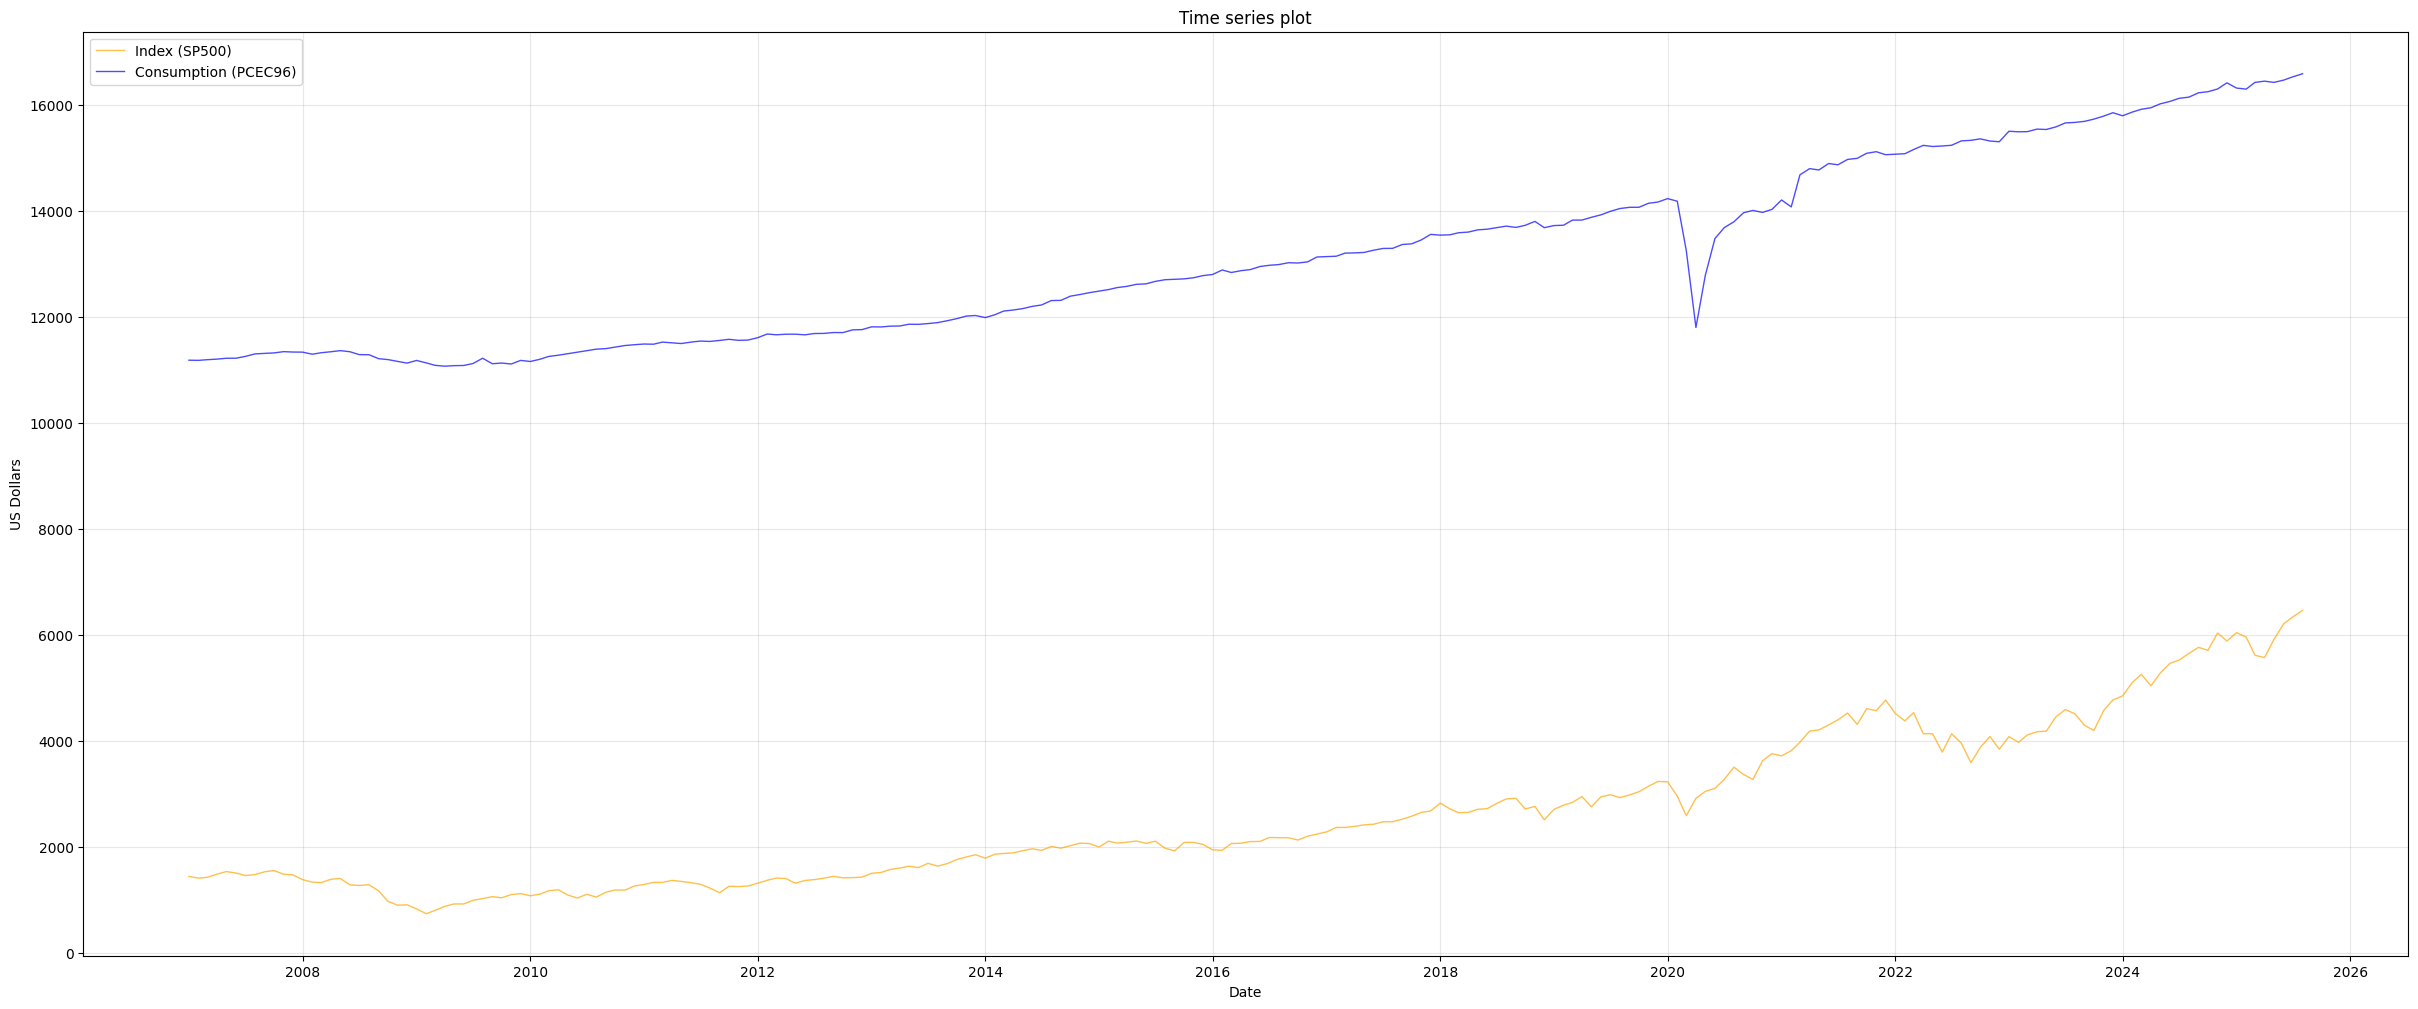

In [3]:
# TIME SERIES
plt.figure(figsize=(30, 12))
plt.plot(data['Date'], data['Index'], linewidth=1, color='orange', alpha=0.7)
plt.plot(data['Date'], data['Consumption'], linewidth=1, color='blue', alpha=0.7)
plt.title('Time series plot')
plt.xlabel('Date')
plt.ylabel('US Dollars')
plt.legend(['Index (SP500)', 'Consumption (PCEC96)'])
plt.grid(True, alpha=0.3)

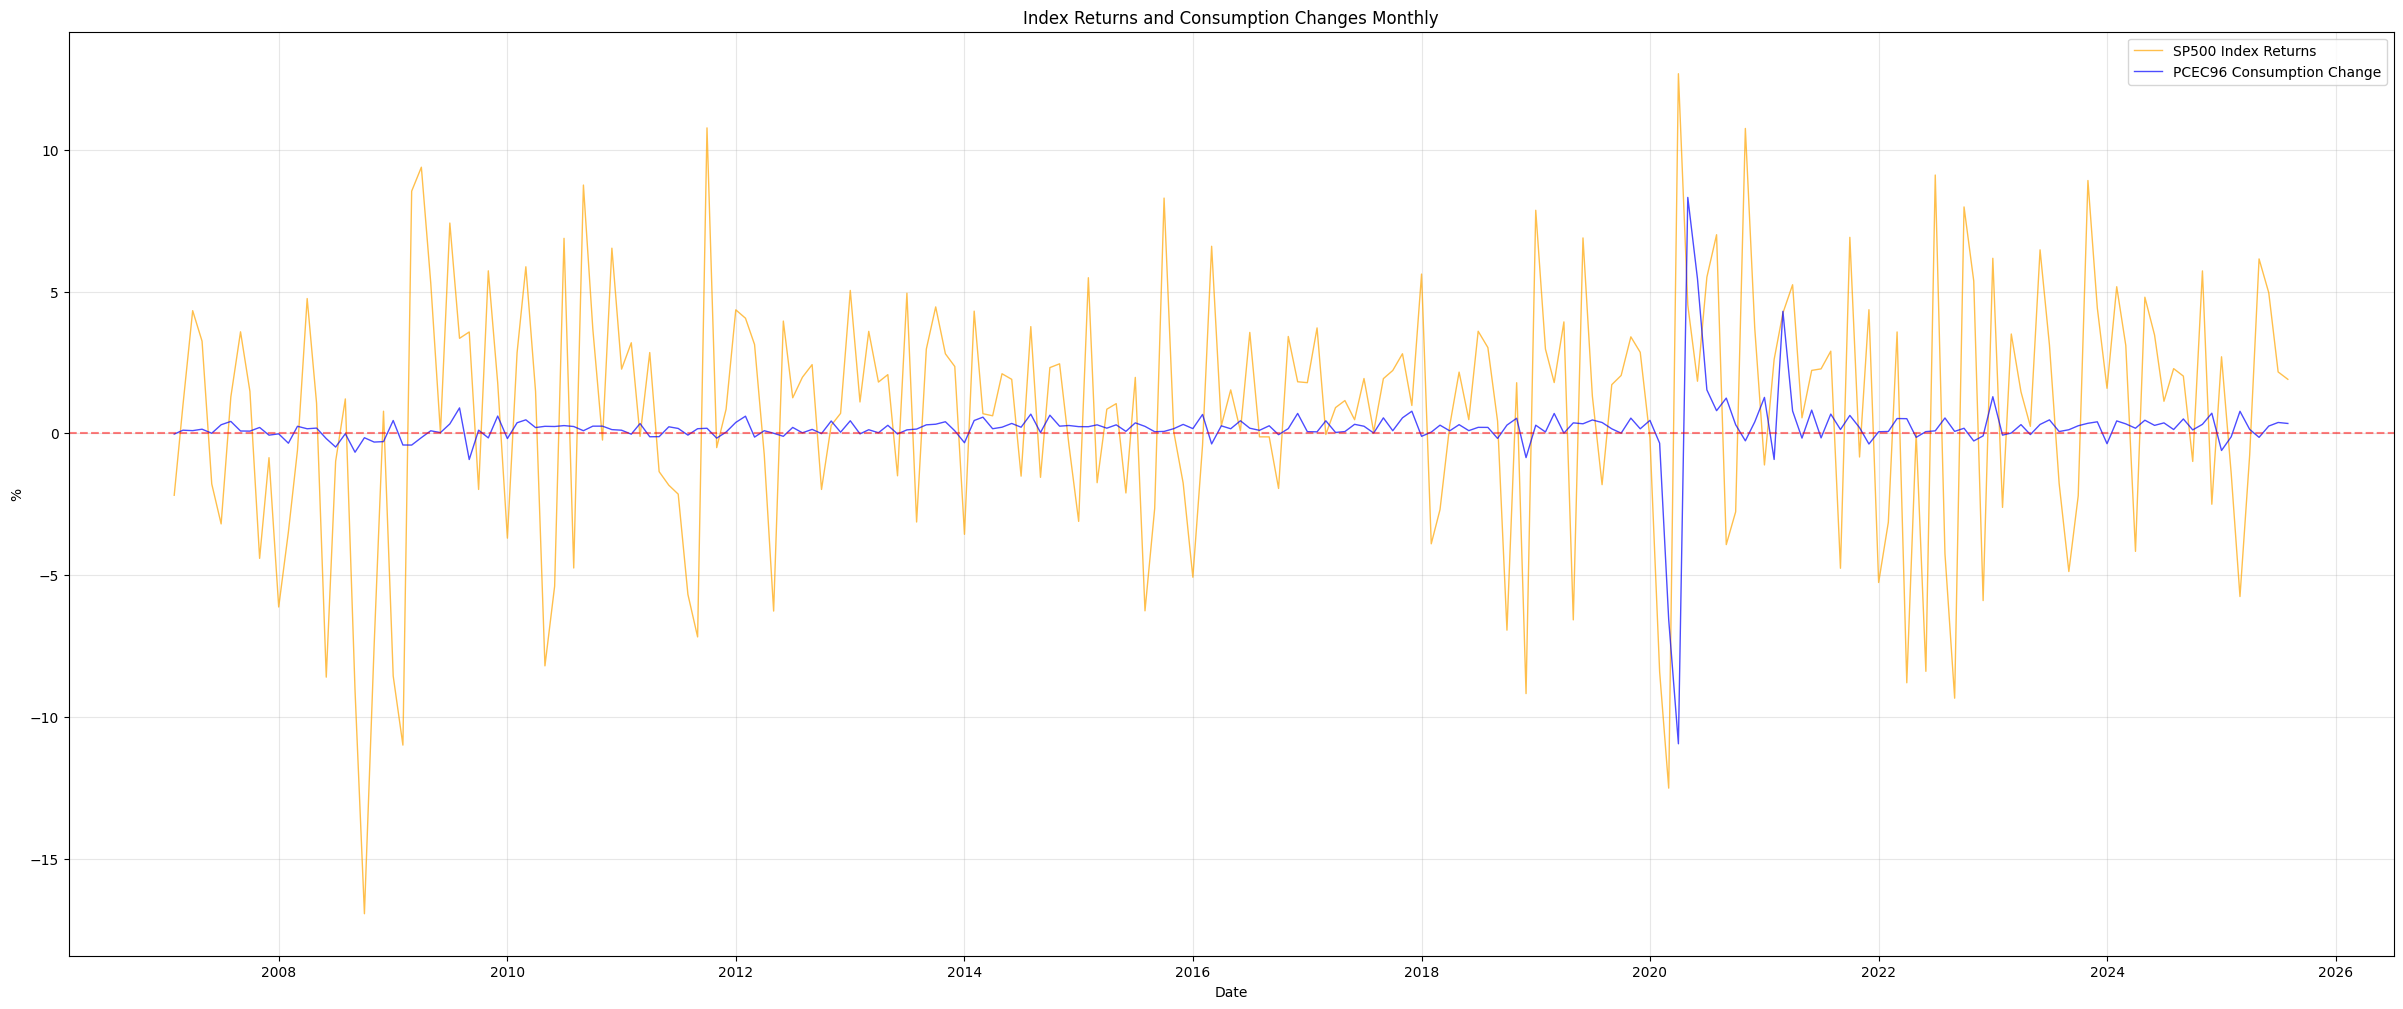

In [4]:
# RETURNS

data['Index Returns'] = data['Index'].pct_change() * 100
data['Consumption Change'] = data['Consumption'].pct_change() * 100

plt.figure(figsize=(30, 12))
plt.plot(data['Date'], data['Index Returns'], linewidth=1, color='orange', alpha=0.7)
plt.plot(data['Date'], data['Consumption Change'], linewidth=1, color='blue', alpha=0.7)
plt.title('Index Returns and Consumption Changes Monthly')
plt.xlabel('Date')
plt.ylabel('%')
plt.legend(['SP500 Index Returns', 'PCEC96 Consumption Change'])
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

Emperical features of the series:

* The S&P 500 returns exhibit significantly higher volatility than PCEC96. The series frequently experiences large positive and negative spikes, often exceeding ~5% and reaching extremes around ~10% to ~-15%. PCEC96 changes are stable and smooth compared to the S&P 500. The monthly changes almost always remain within the narrow band of ~1%.
* Periods of high volatility of the S&P 500 returns cluster together: around the 2008-2009 Financial Crisis and the 2020 COVID-19.
* The 2020 COVID-19 is the single most significant deviation of the PCEC96 from its smooth behavior. The series shows sharp drop (~ -10%) followed immediately by an equally sharp hike (~ +8%).
* The largest negative changes of the S&P 500 returns are extremely sharp, most notably in 2008 and the first half of 2020. This indicates negative skewness (more frequent or larger extreme negative movements than positive ones) compared to the low-volatility PCEC96 series.
* The PCEC96 series generally remains slightly positive, it follows an upward trend over time.

#c) and d)

CCAPM pricing equation:
$$E_t \left[ \beta (1 + r_{t+1}) \left( \frac{c_{t+1}}{c_t} \right)^{\gamma} - 1 \right] = 0$$


The pricing Error $u_{t+1}(\theta)$ for the GMM (moment scalar):

$$u_{t+1}(\theta) = \beta (1 + r_{t+1}) \left( \frac{c_{t+1}}{c_t} \right)^{\gamma} - 1$$

The moment condition is $g_t(\theta) = u_{t+1}(\theta) \cdot Z_t$.

The unconditional expected value of this moment condition must be zero:

$$E[g_t(\theta)] = E \left[ u_{t+1}(\theta) \cdot Z_t \right] = 0$$

The vector of parameters to be estimated is $\theta' = [\beta, \gamma]$.

Since there are $K=2$ parameters, we need at least $M=2$ moment conditions (i.e., $M=2$ instruments). The instruments $Z_t$ must be valid ($Z_t$ has to be measurable at time $t$, i.e. contained in the information set $\Omega_t$), relevant ($Z_t$ must be correlated with the pricing error $u_{t+1}(\theta)$)

* Instrument 1 ($Z_{1t}$) - constant 1. Known at time $t$. Including the constant ensures that the unconditional mean of the pricing error is zero: $E[u_{t+1}(\theta) \cdot 1] = 0$.

* Instrument 2 ($Z_{2t}$) - lagged net market return $r_{t}$. Known at time $t$. Agents use past returns to forecast future returns, so it is a valid element of the information set $\operatorname{E}_t[r_{t}]$.

* Instrument 3 ($Z_{3t}$) - lagged consumption growth $c_t/c_{t-1}$. Known at time $t$. Agents use the most recent consumption growth rate to form their expectation of next period's consumption growth, $\operatorname{E}_t\left[\frac{c_{t+1}}{c_t}\right]$

The full vector of instruments for the over-identified system ($M=3$ instruments for $K=2$ parameters) is:$$Z_t = \begin{pmatrix} 1 \\ r_t \\ \frac{c_{t}}{c_{t-1}} \end{pmatrix}$$


The full vector of unconditional moment conditions for GMM is:$$\mathbf{E}[g_t(\theta)] = E \left[ u_{t+1}(\theta) \cdot Z_t \right] = E \begin{pmatrix} g_{1t}(\theta) \\ g_{2t}(\theta) \\ g_{3t}(\theta) \end{pmatrix} = E \begin{pmatrix} u_{t+1}(\theta) \cdot 1 \\ u_{t+1}(\theta) \cdot r_t \\ u_{t+1}(\theta) \cdot \frac{c_{t}}{c_{t-1}} \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix}$$


The over-identified system allows for the estimation of $\hat{\beta}$ and $\hat{\gamma}$, and the computation of the J-test (test of over-identifying restrictions). The goal is to find the $\hat{\theta}$ that makes the sample moments $g_T(\theta)$ as close to zero as possible, weighted by the matrix $W$. The GMM objective function:

$${\hat{\theta}_{GMM}} = \arg \min_{\theta} \left[ {g_T(\theta)'} \cdot W \cdot {g_T(\theta)} \right]$$

# e)

Since we are using the over-identified system with $M=3$ instruments, the function will take $\theta = [\beta, \gamma]'$ and uploaded SP500 index returns and PCEC96 consumer consumption data, and return a $3 \times 1$ vector of empirical moments.

In [5]:
def calculate_empirical_moments(theta: np.ndarray, data: pd.DataFrame) -> np.ndarray:
    # unpack parameters
    beta, gamma = theta[0], theta[1]

    # define the Instruments Z_t (all known at time t)
    Z_1t = np.ones(len(data))
    Z_2t = data['Index Returns'] / 100
    Z_3t = data['Consumption'] / data['Consumption'].shift(1)

    # Gross Return
    # shift forward by 1 period to align R_{t+1} with time t instruments.
    R_gross = 1 + (data['Index Returns'] / 100).shift(1)

    # Consumption growth (c_{t+1}/c_t).
    # The ratio of the next period's consumption to the current period's consumption.
    consumption_growth = data['Consumption'].shift(-1) / data['Consumption']

    # the pricing error u_{t+1}(theta) = beta * (c_{t+1}/c_t)^(gamma) * (1+r_{t+1}) - 1
    u_t_plus_1 = (beta * R_gross * (consumption_growth**gamma)) - 1

    # g_t(theta) = u_{t+1}(theta) * Z_t
    g_1t = u_t_plus_1 * Z_1t
    g_2t = u_t_plus_1 * Z_2t
    g_3t = u_t_plus_1 * Z_3t

    # combine into a DataFrame for easy handling of NaNs
    g_t = pd.DataFrame({
        'g1': g_1t,
        'g2': g_2t,
        'g3': g_3t
    })

    # drop rows with NaNs (due to the shifts for t+1 and t-1 terms). to ensure proper alignment and avoid division by zero/missing data.
    g_t.dropna(inplace=True)

    # Calculate the Empirical Moment Conditions (Sample Mean): g_T(theta) = (1/T) * sum(g_t(theta))
    g_T_theta = g_t.mean().values.reshape(-1, 1)

    return g_T_theta

Sample moment:

$$
g_T(\theta)
= \frac{1}{T} \sum_{t=1}^T g_t(\theta).
$$

#f)

To estimate the parameters $\mathbf{\theta} = [\beta, \gamma]'$ using the GMM, we will need:
* The moment function from e).
* An optimization routine to minimize the GMM objective function.
* A method to calculate the optimal weighting matrix ($W$) and the asymptotic variance-covariance matrix ($V$) for inference.

We will use Python's `scipy.optimize` for minimization.

In [6]:
from scipy.optimize import minimize
from numpy.linalg import inv, det
from scipy.stats import chi2

GMM objective (given weighting matrix $W$):

$$
J_T(\theta; W)
= g_T(\theta)^\top W\, g_T(\theta).
$$

In [7]:
def gmm_objective_function(theta, data, W=np.eye(3)) -> float:
    g_T = calculate_empirical_moments(theta, data)
    J = g_T.T @ W @ g_T
    return J[0, 0]

Long-run covariance estimator:

$$
\widehat{\Omega}
= \sum_{\ell=-L}^{L} \widehat{\Omega}_\ell,
$$

where

$$
\widehat{\Omega}_\ell
= \frac{1}{T}
\sum_{t = |\ell|+1}^{T}
\tilde g_t \, \tilde g_{t-|\ell|}^\top,
$$

and the demeaned moments are

$$
\tilde g_t = g_t(\hat{\theta}^{(1)}) - \bar g(\hat{\theta}^{(1)}),
\qquad
\bar g(\hat{\theta}^{(1)}) = g_T(\hat{\theta}^{(1)}).
$$

A Newey–West kernel can be applied to each $\widehat{\Omega}_\ell$.

In [8]:
# This function estimates the long-run covariance matrix GAMMA, required for the optimal W
def get_OMEGA_matrix(theta: np.ndarray, data: pd.DataFrame, max_lag: int = 12) -> np.ndarray:
    beta, gamma = theta[0], theta[1]
    R_gross = 1 + (data['Index Returns'] / 100).shift(1)
    consumption_growth = data['Consumption'].shift(1) / data['Consumption']
    u_t_plus_1 = (beta * R_gross * (consumption_growth**gamma)) - 1
    g_1t = u_t_plus_1 * np.ones(len(data))
    g_2t = u_t_plus_1 * data['Index Returns'] / 100
    g_3t = u_t_plus_1 * data['Consumption'] / data['Consumption'].shift(1)
    g_t = pd.DataFrame({
        'g1': g_1t,
        'g2': g_2t,
        'g3': g_3t
    }).dropna().values
    T = g_t.shape[0]
    M = g_t.shape[1]
    OMEGA_matrix = (g_t.T @ g_t) / T

    # Calculate OMEGA_j (autocovariance for j > 0)
    for j in range(1, max_lag + 1):
        weight = 1 - (j / (max_lag + 1))  # Newey-West Kernel
        # Cross-product of g_t with g_{t-j}
        gamma_j = (g_t[j:].T @ g_t[:-j]) / T
        OMEGA_matrix += weight * (gamma_j + gamma_j.T)
    return OMEGA_matrix

First-step GMM. Use an identity weighting matrix $W_1 = I_M$ and minimize objective function:

$$
\hat{\theta}^{(1)}
= \arg\min_{\theta} J_T(\theta; I).
$$


In [9]:
# Initial guess for [beta, gamma]. Must be non-negative and beta < 1.
theta_initial = np.array([0.98, 2.0])

# Constraints: beta is (0, 1), gamma is (0, infinity).
# We use loose bounds to ensure positivity and consistency.
bounds = ((0.01, 1.0), (0.01, None))

W1 = np.eye(3) # Identity matrix
results_1st = minimize(
    gmm_objective_function,
    theta_initial,
    args=(data, W1),
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True}
)
theta_hat_1 = results_1st.x
print(f"First-Stage Estimates (beta, gamma): {theta_hat_1}")

First-Stage Estimates (beta, gamma): [0.9884084 2.0000297]


/tmp/ipython-input-584509260.py:9: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  results_1st = minimize(


Optimal weighting matrix:

$$
W^\ast = \widehat{\Omega}^{-1}.
$$

Second-step minimize objection function using the optimal weighting matrix (efficient GMM estimator):

$$
\hat{\theta}
= \arg\min_{\theta} J_T(\theta; W^\ast).
$$

In [10]:
# Calculate the Optimal Weighting Matrix (W2)
S_hat_1 = get_OMEGA_matrix(theta_hat_1, data)
W2 = inv(S_hat_1)

# Minimize using the Optimal Weighting Matrix
results_optimal = minimize(
    gmm_objective_function,
    theta_hat_1, # Use 1st stage results as new starting point
    args=(data, W2),
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True}
)
theta_hat_gmm = results_optimal.x
print("\n====================================")
print("GMM estimates")
print(f"Beta: {theta_hat_gmm[0]:.4f}")
print(f"Gamma:  {theta_hat_gmm[1]:.4f}")
print(f"J-Statistic (Moment Error): {results_optimal.fun:.6f}")
print("\n====================================")

/tmp/ipython-input-712718769.py:6: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  results_optimal = minimize(



GMM estimates
Beta: 0.9920
Gamma:  0.0100
J-Statistic (Moment Error): 0.016071



Asymptotic variance of the optimal GMM estimator:

$$
\operatorname{Var}(\hat{\theta})
\approx
\frac{1}{T}
\left( D^\top W^\ast D \right)^{-1},
$$

where

$$
D = \left. \frac{\partial g_T(\theta)}{\partial \theta^\top} \right|_{\theta=\hat{\theta}}
\qquad (M \times K \text{ matrix}).
$$

J-statistic for overidentifying restrictions:

$$
J = T \cdot J_T(\hat{\theta}; W^\ast)
\;\sim\;
\chi^2_{\,M-K},
$$

under the null hypothesis that the model is correctly specified. In this problem: $M - K = 3 - 2 = 1$

In [11]:
# Estimate the gradient matrix D and the Asymptotic Variance V
# Calculate OMEGA_hat for the final estimates (required for V)
S_hat_gmm = get_OMEGA_matrix(theta_hat_gmm, data)

# Numerically estimate the gradient matrix D (M x K, 3x2)
T = data.dropna().shape[0] # Effective number of observations
eps = 1e-6
D_hat = np.zeros((3, 2))

for i in range(2): # For each parameter (beta, gamma)
    # Calculate moment function at theta + eps*e_i
    theta_plus = theta_hat_gmm.copy()
    theta_plus[i] += eps
    g_plus = calculate_empirical_moments(theta_plus, data)

    # Calculate moment function at theta - eps*e_i
    theta_minus = theta_hat_gmm.copy()
    theta_minus[i] -= eps
    g_minus = calculate_empirical_moments(theta_minus, data)

    # Numerical partial derivative: (g_plus - g_minus) / (2*eps)
    D_hat[:, i] = ((g_plus - g_minus) / (2 * eps)).flatten()

# Calculate the Asymptotic Covariance Matrix (V)
# V = (1/T) * [D' * W * D]^{-1} * [D' * W * OMEGA * W * D] * [D' * W * D]^{-1}
# For optimal GMM (W = OMEGA^{-1}), this simplifies to the textbook formula:
# V_gmm = (1/T) * [D' * OMEGA^{-1} * D]^{-1}

DW = D_hat.T @ W2
V_gmm = inv(DW @ D_hat) / T

# Standard Errors are the square root of the diagonal elements
SE = np.sqrt(np.diag(V_gmm))

print("\n--- INFERENCE ---")
results_table = pd.DataFrame({'Estimate': theta_hat_gmm, 'Std. Error': SE}, index=['Beta', 'Gamma'])
results_table['t-stat'] = results_table['Estimate'] / results_table['Std. Error']
print(results_table)

# J-Test for Over-Identifying Restrictions
# J = T * J(theta_hat) ~ Chi^2 with M-K degrees of freedom (3-2 = 1)
J_statistic = T * results_optimal.fun
dof = 3 - 2 # M - K = 3 moments - 2 parameters = 1
p_value = 1 - chi2.cdf(J_statistic, dof)
print(f"\nJ-Test Statistic: {J_statistic:.4f} (df={dof})")
print(f"J-Test p-value: {p_value:.4f}")


--- INFERENCE ---
       Estimate  Std. Error      t-stat
Beta   0.991971     0.00464  213.804765
Gamma  0.010000     1.31125    0.007626

J-Test Statistic: 3.5838 (df=1)
J-Test p-value: 0.0583
